<a href="https://colab.research.google.com/github/Nathan2605/TimeSeriesForecasting/blob/main/ACEA_GROUP%2C_TimeSeries_(ARIMA%2C_Auto_ARIMA%2C_Prophet)_NH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PREDICT WATER AVAILABILTY - ACEA GROUP

**BACKGROUND:** A water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter water bodies are refilled, but during spring and summer they start to drain. To help preserve the health of these water bodies, it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

Acea group is one the leading Italian multiutility operators, listed on Italian Stock Exchange since 1999. The company manages and develops water and electricity networks and environmental services. Acea is the foremost Italian operator in the water services sector supplying 9 million inhabitants in various regions

**ARNO RIVER:** Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it has a relatively torrential regime, due to the nature of the surrounding soils (marl and impermeable clays). Arno results to be the main source of water supply of the metropolitan area of Florence-Prato-Pistoia. The availability of water for this waterbody is evaluated by checking the hydrometric level of the river at the section of Nave di Rosano.

**OBJECTIVE:** Forecast Arno Hydrometry (River Level)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

#TimeSerie tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA and AutoARIMA
from pmdarima import auto_arima

# Prophet
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('River_Arno.csv')
df.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


## Data Preprocessing

In [4]:
print("Number of rows is = ", df.shape[0], " \nNumber of columns is = " , df.shape[1])

Number of rows is =  8217  
Number of columns is =  17


In [5]:
print('Starting date is :' , df['Date'].iloc[0],
      '\nEnding Date is : ',df["Date"].iloc[-1])

Starting date is : 01/01/1998 
Ending Date is :  30/06/2020


In [6]:
# Convert 'Date' to Datetime for Time Series Analysis
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y').dt.date
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
print(round(df.isnull().sum()/df.shape[0]*100,2))

Date                          0.00
Rainfall_Le_Croci            26.66
Rainfall_Cavallina           26.66
Rainfall_S_Agata             26.66
Rainfall_Mangona             26.66
Rainfall_S_Piero             26.66
Rainfall_Vernio              47.88
Rainfall_Stia                84.39
Rainfall_Consuma             84.39
Rainfall_Incisa              44.41
Rainfall_Montevarchi         79.96
Rainfall_S_Savino            84.39
Rainfall_Laterina            84.39
Rainfall_Bibbiena            71.06
Rainfall_Camaldoli           84.39
Temperature_Firenze          24.64
Hydrometry_Nave_di_Rosano     0.58
dtype: float64


**There are null values in the dataset.**

####Handling Missing Data

<Axes: >

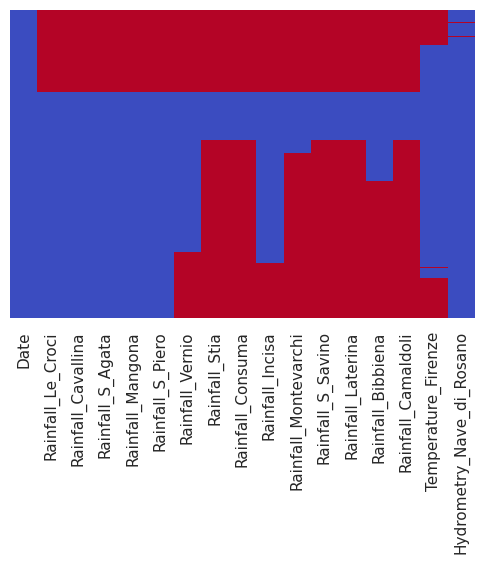

In [8]:
# Visualize Heat Map for Missing Data
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

**Here entire dataset of Arno river is represented by the blue rectangle and each red strips indicates missing value. The value at top is the oldest data and at the bottom is the newest one.**

**From this visualisation it is clear the missing data is at top that is old data, so we can drop those.**

In [9]:
# Remove old rows
df = df[df['Rainfall_Le_Croci'].notna()].reset_index(drop=True)

In [10]:
print('Starting date After Deletion of old  missing data is :' ,
      df['Date'].iloc[0],
      '\nEnding Date  After Deletion of old missing data is : ',
      df['Date'].iloc[-1])

Starting date After Deletion of old  missing data is : 2004-01-01 00:00:00 
Ending Date  After Deletion of old missing data is :  2020-06-30 00:00:00


<Axes: >

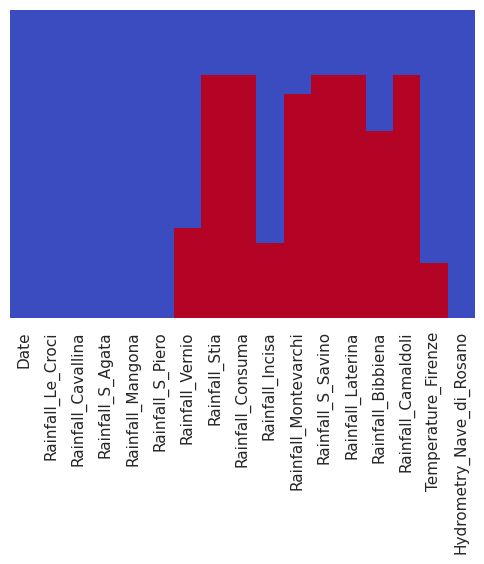

In [11]:
# Visualize Heat Map for Missing Data
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

In [12]:
print(round(df.isnull().sum()/df.shape[0]*100,2))

Date                          0.00
Rainfall_Le_Croci             0.00
Rainfall_Cavallina            0.00
Rainfall_S_Agata              0.00
Rainfall_Mangona              0.00
Rainfall_S_Piero              0.00
Rainfall_Vernio              28.92
Rainfall_Stia                78.71
Rainfall_Consuma             78.71
Rainfall_Incisa              24.20
Rainfall_Montevarchi         72.67
Rainfall_S_Savino            78.71
Rainfall_Laterina            78.71
Rainfall_Bibbiena            60.54
Rainfall_Camaldoli           78.71
Temperature_Firenze          17.96
Hydrometry_Nave_di_Rosano     0.05
dtype: float64


**We have 6 variables with more than 70% of Nan. Let's verify whether they are significant or not.**

<Axes: >

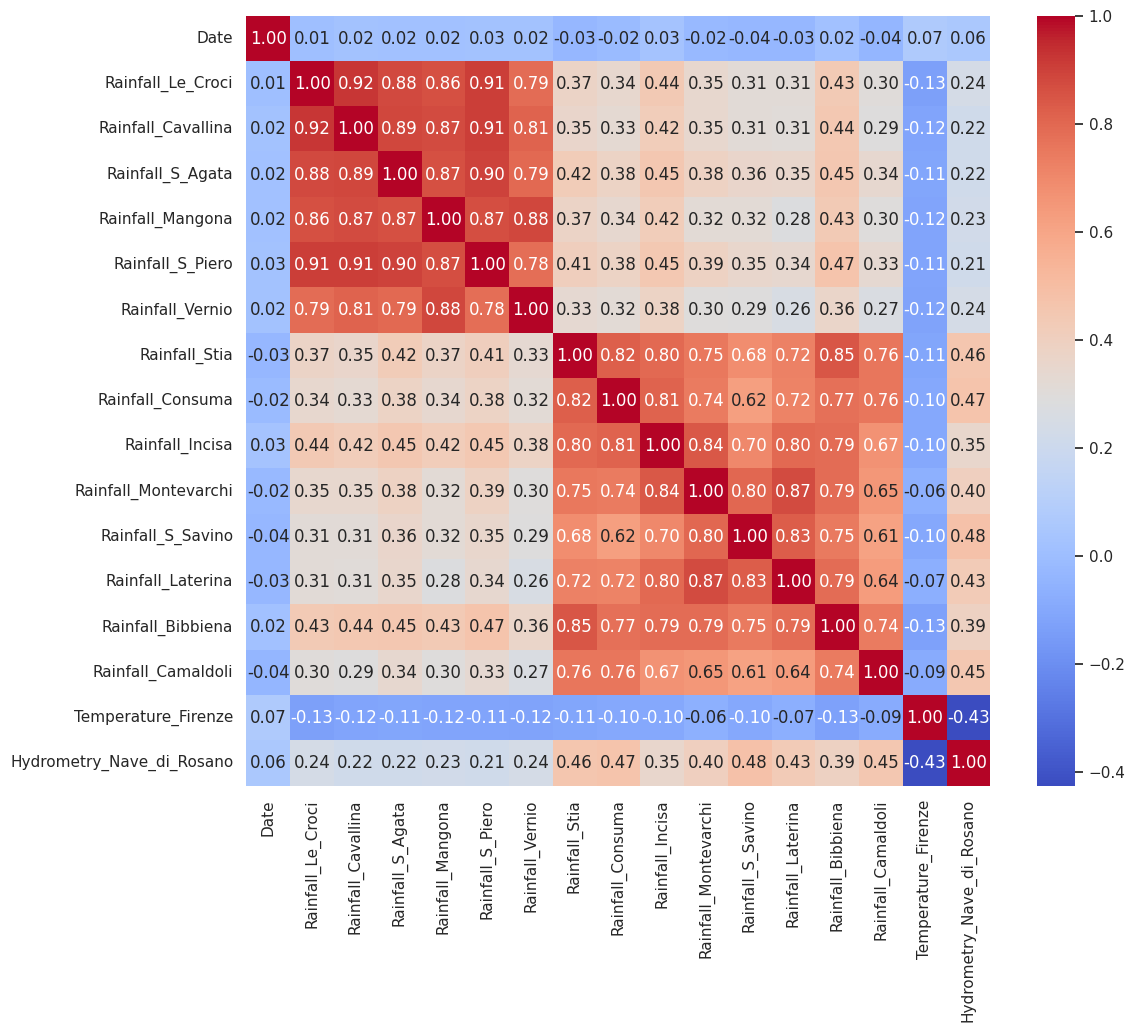

In [13]:
#correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

When analyzing the columns with missing values (`NaN`), we observe the following:

1. **Columns with high correlation among themselves:**
   - We notice that columns such as `Rainfall_Stia`, `Rainfall_Consuma`, `Rainfall_S_Savino`,`Rainfall_Laterina`, and `Rainfall_Camaldoli` have a strong correlation (> 0.75) with each other, indicating redundant information.
   - Therefore, we will keep only one representative column.

2. **Columns with unique information:**
   - We see that `Temperature_Firenze` has low correlation with the precipitation columns, which suggests it provides unique and valuable information.
   - Thus, we will impute the missing values rather than removing this column.

3. **Columns with low correlation:**
   - We observe that columns such as `Rainfall_Incisa`, `Rainfall_Montevarchi`, and `Rainfall_Bibbiena` show weak correlations (< 0.4) with other variables. These columns are unlikely to contribute meaningfully to the analysis.
   - As a result, we will remove them to reduce noise and simplify the dataset.


In [14]:
#remove redundant and unnecesary information
columns_to_drop = ['Rainfall_Consuma', 'Rainfall_Camaldoli', 'Rainfall_Incisa','Rainfall_Stia','Rainfall_S_Savino','Rainfall_Laterina' ,'Rainfall_Montevarchi', 'Rainfall_Bibbiena']
df = df.drop(columns=columns_to_drop)

In [15]:
df.isnull().sum()/df.shape[0]*100

,0
Date,0.000000
Rainfall_Le_Croci,0.000000
Rainfall_Cavallina,0.000000
Rainfall_S_Agata,0.000000
Rainfall_Mangona,0.000000
Rainfall_S_Piero,0.000000
Rainfall_Vernio,28.924660
Temperature_Firenze,17.955526
Hydrometry_Nave_di_Rosano,0.049784


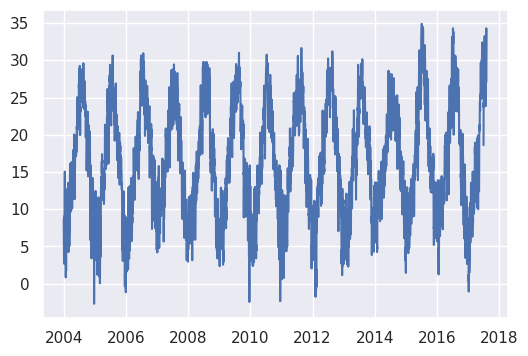

In [16]:
# Temperature_Firenze column visualization
plt.plot(df['Date'], df['Temperature_Firenze'])

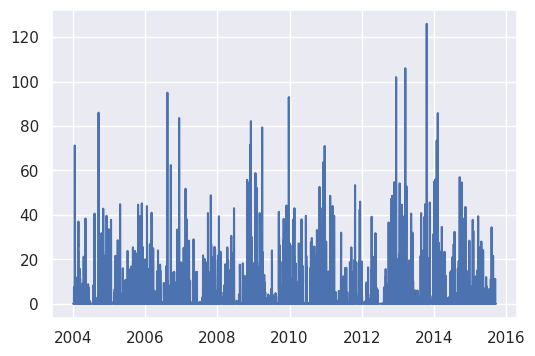

In [17]:
# Rainfall_Vernio column visualization
plt.plot(df['Date'], df['Rainfall_Vernio'])

In [18]:
# Stationarity test
def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [19]:
# Stationarity test - Temperature_Firenze
test_stationarity(df[df['Temperature_Firenze'].notna()]['Temperature_Firenze'])

Dickey-Fuller test results:


,0
Test Statistic,-4.090107
p-value,0.001006
#Lags Used,13.000000
Number of Observations Used,4930.000000
Critical Value (1%),-3.431677
Critical Value (5%),-2.862126
Critical Value (10%),-2.567082


In [20]:
# Stationarity test - Rainfall_Vernio
test_stationarity(df[df['Rainfall_Vernio'].notna()]['Rainfall_Vernio'])

Dickey-Fuller test results:


,0
Test Statistic,-1.609803e+01
p-value,5.167604e-29
#Lags Used,1.100000e+01
Number of Observations Used,4.271000e+03
Critical Value (1%),-3.431882e+00
Critical Value (5%),-2.862217e+00
Critical Value (10%),-2.567130e+00


**The seasonality test is positive (p-value<0.05), which implies that the values follow a replicable pattern. Therefore, we will use the latest observations to fill in the missing values.**

In [21]:
def fill_missing_values(df, column_name):
  Nan_cantity = df[column_name].isna().sum()
  previous_temp = df.loc[df[column_name].notna()][column_name].tail(Nan_cantity).tolist()
  df.loc[df[column_name].isna(), column_name] = previous_temp
  return df

In [22]:
#Fill in unobserved years with the detected pattern of previous years.
df = fill_missing_values(df, 'Temperature_Firenze')
df = fill_missing_values(df, 'Rainfall_Vernio')

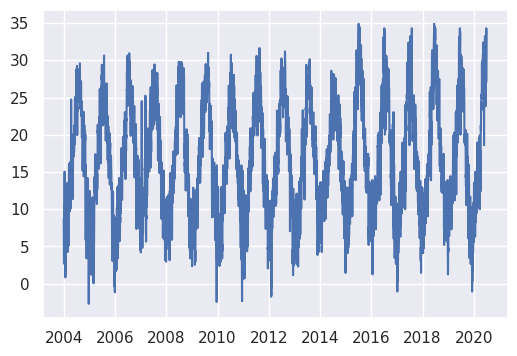

In [23]:
plt.plot(df['Date'], df['Temperature_Firenze'])

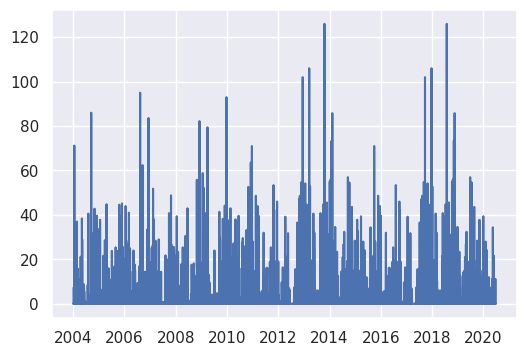

In [24]:
plt.plot(df['Date'], df['Rainfall_Vernio'])

In [25]:
df.isnull().sum()/df.shape[0]*100

,0
Date,0.000000
Rainfall_Le_Croci,0.000000
Rainfall_Cavallina,0.000000
Rainfall_S_Agata,0.000000
Rainfall_Mangona,0.000000
Rainfall_S_Piero,0.000000
Rainfall_Vernio,0.000000
Temperature_Firenze,0.000000
Hydrometry_Nave_di_Rosano,0.049784


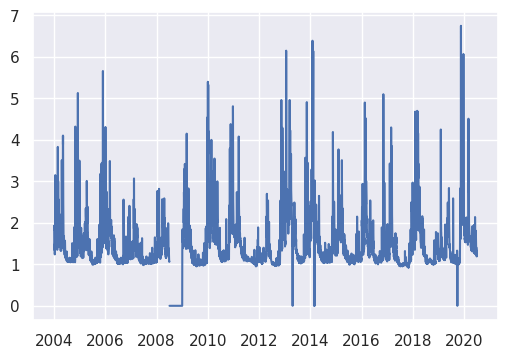

In [26]:
# Target Hydrometry column visualization
plt.plot(df['Date'], df['Hydrometry_Nave_di_Rosano'])

**Plotting the time series reveals that there seem to be some zero values that seems to be nulls for river hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards**

In [27]:
# Replace zeros by Nan
df['Hydrometry_Nave_di_Rosano'] = df['Hydrometry_Nave_di_Rosano'].replace(0, np.nan)

In [28]:
## Filling missing values by Interpolación lineal
df['Hydrometry_Nave_di_Rosano'] = df['Hydrometry_Nave_di_Rosano'].interpolate(method='linear')

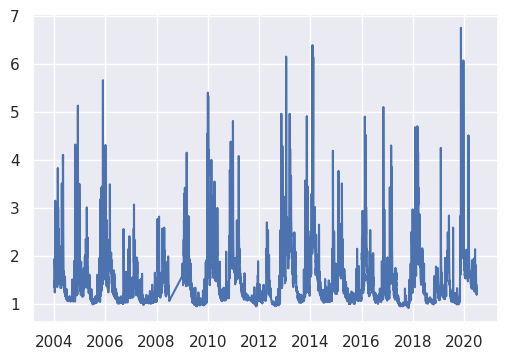

In [29]:
# visualization
plt.plot(df['Date'], df['Hydrometry_Nave_di_Rosano'])

In [30]:
df.isnull().sum()/df.shape[0]*100

,0
Date,0.0
Rainfall_Le_Croci,0.0
Rainfall_Cavallina,0.0
Rainfall_S_Agata,0.0
Rainfall_Mangona,0.0
Rainfall_S_Piero,0.0
Rainfall_Vernio,0.0
Temperature_Firenze,0.0
Hydrometry_Nave_di_Rosano,0.0


##Time Serie Analysis

In [31]:
# Time Serie Decomposition
decomposition = seasonal_decompose(df['Hydrometry_Nave_di_Rosano'], period = 365)
decomposition

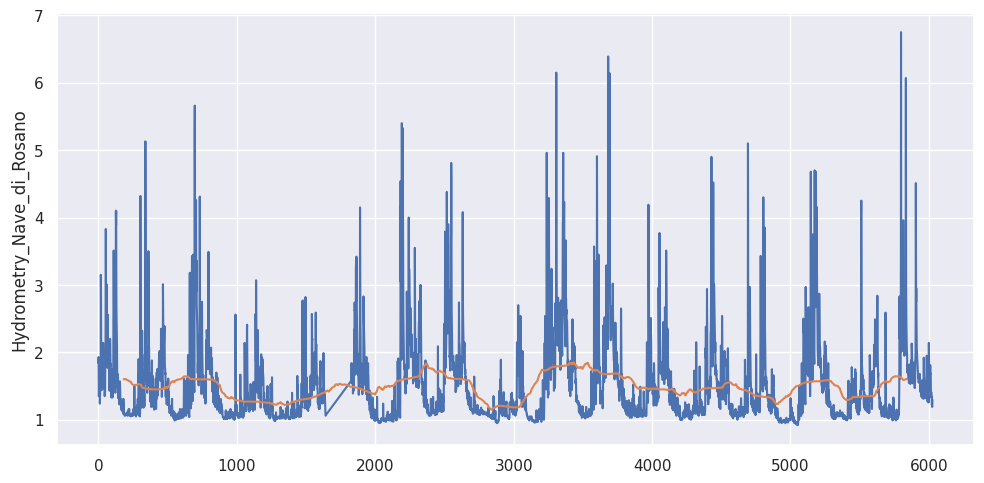

In [32]:
# Trend Analysis
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df['Hydrometry_Nave_di_Rosano'])
sns.lineplot(data = trend)
plt.tight_layout()
plt.show()

**The time series shows significant fluctuations with recurrent peaks, while the smoothed line highlights a general trend over time.**

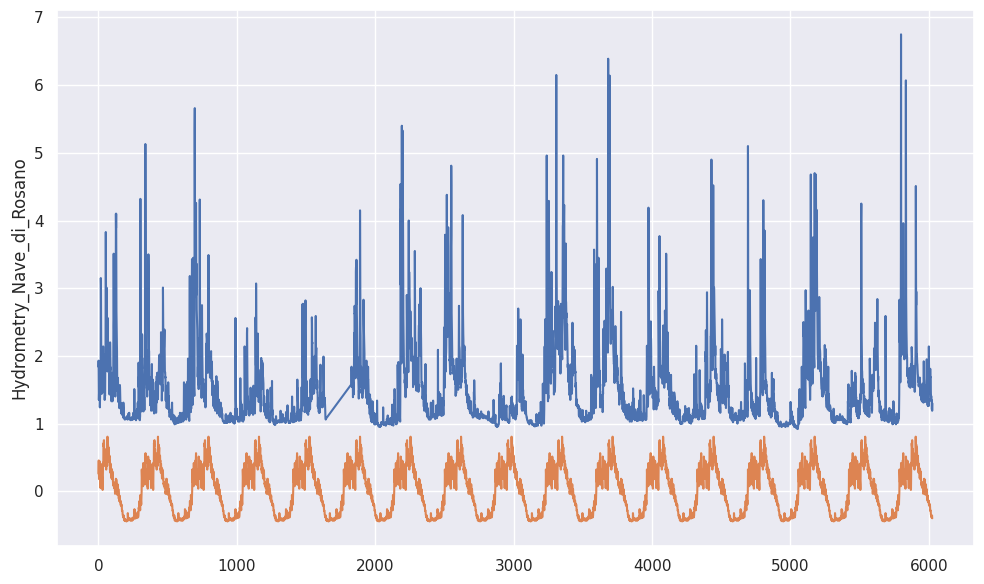

In [33]:
# Stationarity Analysis
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 6))
sns.lineplot(data = df['Hydrometry_Nave_di_Rosano'])
sns.lineplot(data = seasonal)
plt.tight_layout()
plt.show()

**The original time series overlaps with its seasonal component, showing a clear recurring pattern that indicates marked Stationarity in the data.**

In [34]:
# Dicky Fuller Stationarity Test
test_stationarity(df['Hydrometry_Nave_di_Rosano'])

Dickey-Fuller test results:


,0
Test Statistic,-8.449838e+00
p-value,1.673945e-13
#Lags Used,1.600000e+01
Number of Observations Used,6.009000e+03
Critical Value (1%),-3.431439e+00
Critical Value (5%),-2.862021e+00
Critical Value (10%),-2.567026e+00


**Stationarity is verified, with a p-value < 0.05**

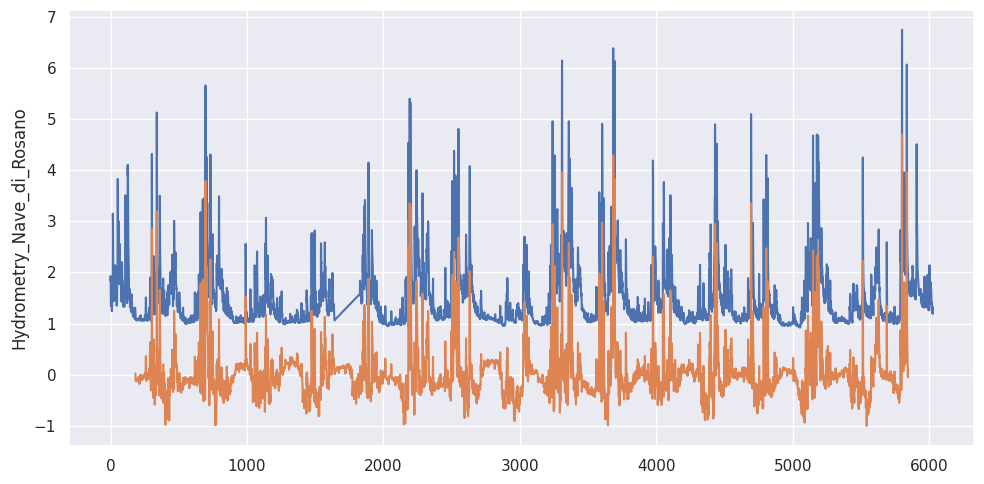

In [35]:
# Variability Analysis
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))
sns.lineplot(data = df['Hydrometry_Nave_di_Rosano'])
sns.lineplot(data = residual)
plt.tight_layout()
plt.show()

##Feature Engineering

In [36]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Temperature_Firenze,Hydrometry_Nave_di_Rosano,year,month,day,day_of_year,quarter,season
0,2004-01-01,0.0,0.0,0.4,0.0,0.0,0.0,8.65,1.84,2004,1,1,1,1,1
1,2004-01-02,0.0,0.0,0.0,0.0,0.0,0.0,7.10,1.93,2004,1,2,2,1,1
2,2004-01-03,0.0,0.0,0.0,0.0,0.0,0.0,5.50,1.61,2004,1,3,3,1,1
3,2004-01-04,0.0,0.0,0.0,0.0,0.0,0.0,3.55,1.35,2004,1,4,4,1,1
4,2004-01-05,0.0,0.0,0.0,0.0,0.2,0.0,2.70,1.44,2004,1,5,5,1,1


##Autocorrelation Analysis


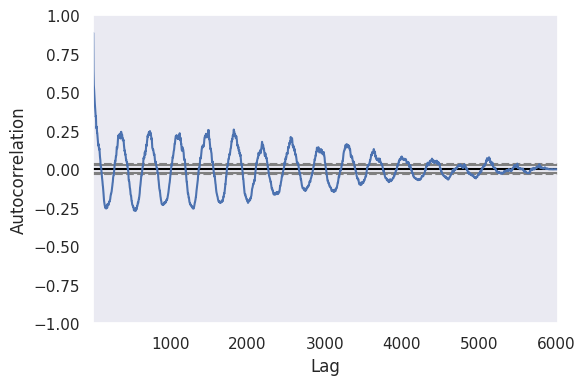

In [37]:
# Autocorrelation Function (ACF)
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Hydrometry_Nave_di_Rosano'])
plt.show()

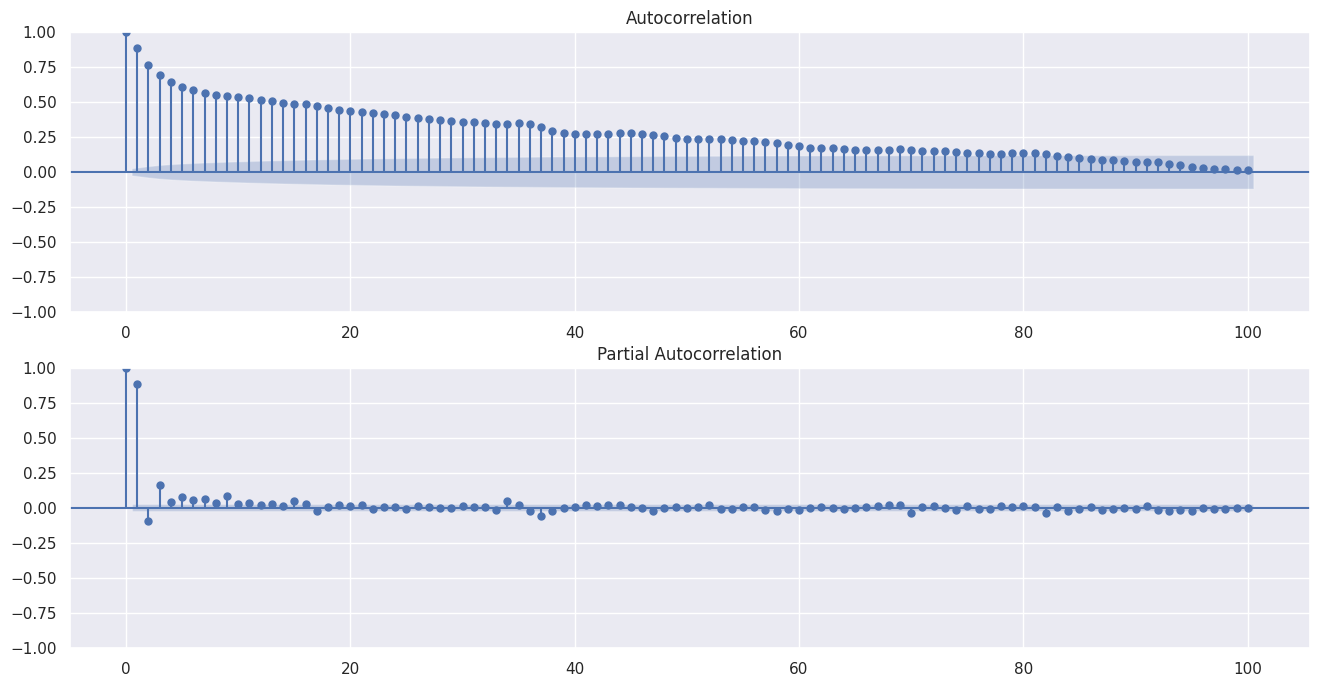

In [38]:
# Partial Autocorrelation Function (PACF)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['Hydrometry_Nave_di_Rosano'], lags=100, ax=ax[0])
plot_pacf(df['Hydrometry_Nave_di_Rosano'], lags=100, ax=ax[1])

plt.show()

##Modeling

In [39]:
# create target
target = 'Hydrometry_Nave_di_Rosano'

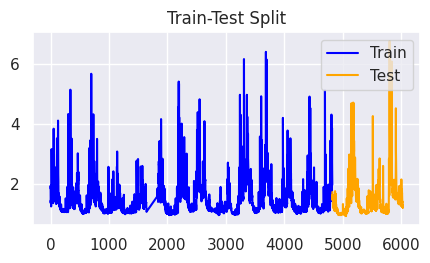

In [40]:
# Split the data into train (80%) and test (20%)
train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Visualize the split
plt.figure(figsize=(8,4))
plt.plot(train[target], label='Train', color='blue')
plt.plot(test[target], label='Test', color='orange')
plt.title('Train-Test Split')
plt.legend()
plt.show()

###ARIMA MODEL

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA MAE: 0.418, MSE: 0.354


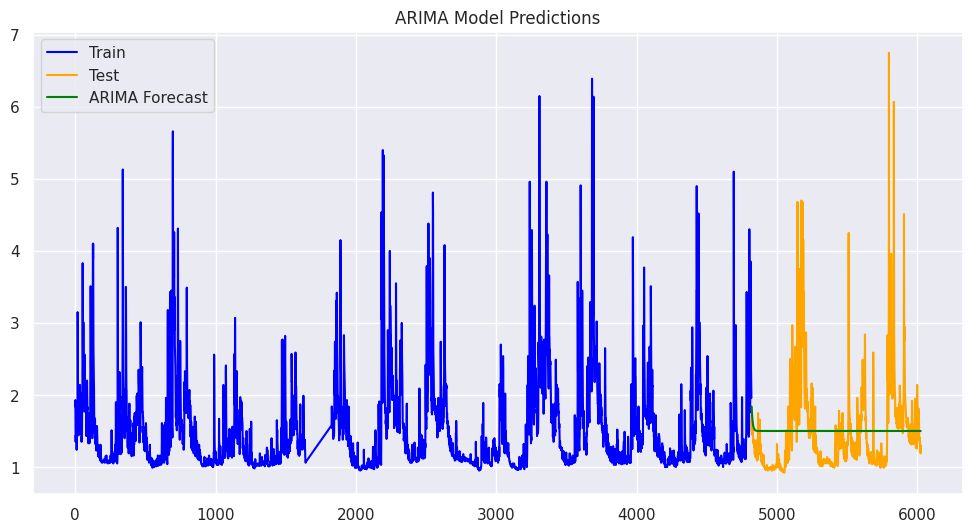

In [41]:
# Fit ARIMA model
arima_model = ARIMA(train[target], order=(2, 0, 1))
arima_fitted = arima_model.fit()

# Forecast
arima_forecast = arima_fitted.forecast(steps=len(test))

# Evaluate ARIMA performance
mae_arima = mean_absolute_error(test[target], arima_forecast)
mse_arima = mean_squared_error(test[target], arima_forecast)
print(f'ARIMA MAE: {mae_arima:.3f}, MSE: {mse_arima:.3f}')

# Plot ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(train[target], label='Train', color='blue')
plt.plot(test[target], label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Model Predictions')
plt.legend()

**The ARIMA model fails to capture the variability and peaks in the test set, indicating that it might not be suitable for forecasting highly volatile or seasonal data in this case.**

###AUTO-ARIMA MODEL

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1019.171, Time=4.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18295.576, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1499.686, Time=0.52 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12494.529, Time=2.71 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1255.342, Time=3.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1416.728, Time=1.86 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1018.135, Time=5.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1038.271, Time=4.96 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=6.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1007.452, Time=4.93 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1017.631, Time=4.93 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=1010.988, Time=5.45 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1009.780, Time=7.20 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1019.712, Time=2.70 sec
 ARIMA(4,0,4)(0,0,0)[0]             

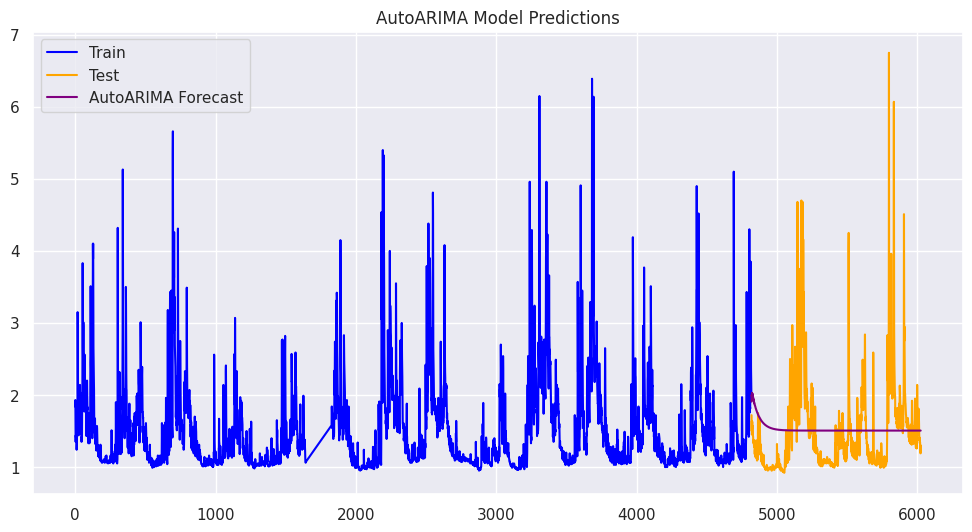

In [42]:
# Fit AutoARIMA
auto_arima_model = auto_arima(train[target], seasonal=False, trace=True, stepwise=True)

# Forecast
auto_arima_forecast = auto_arima_model.predict(n_periods=len(test))

# Evaluate AutoARIMA performance
mae_autoarima = mean_absolute_error(test[target], auto_arima_forecast)
mse_autoarima = mean_squared_error(test[target], auto_arima_forecast)
print(f'AutoARIMA MAE: {mae_autoarima:.3f}, MSE: {mse_autoarima:.3f}')

# Plot AutoARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(train[target], label='Train', color='blue')
plt.plot(test[target], label='Test', color='orange')
plt.plot(test.index, auto_arima_forecast, label='AutoARIMA Forecast', color='purple')
plt.title('AutoARIMA Model Predictions')
plt.legend()
plt.show()

**The AutoARIMA model exhibits similar behavior to the ARIMA model in that it does not capture the volatility or peaks of the data in the test set. Although the fitting is automatic, it remains insufficient to correctly model the complex nature of the time series.**

###PROPHET MODEL

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhr94yke/0gh16b5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprhr94yke/f6kw9s4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67142', 'data', 'file=/tmp/tmprhr94yke/0gh16b5p.json', 'init=/tmp/tmprhr94yke/f6kw9s4n.json', 'output', 'file=/tmp/tmprhr94yke/prophet_modelij3z0d4n/prophet_model-20241121002104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:21:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.331, MSE: 0.287


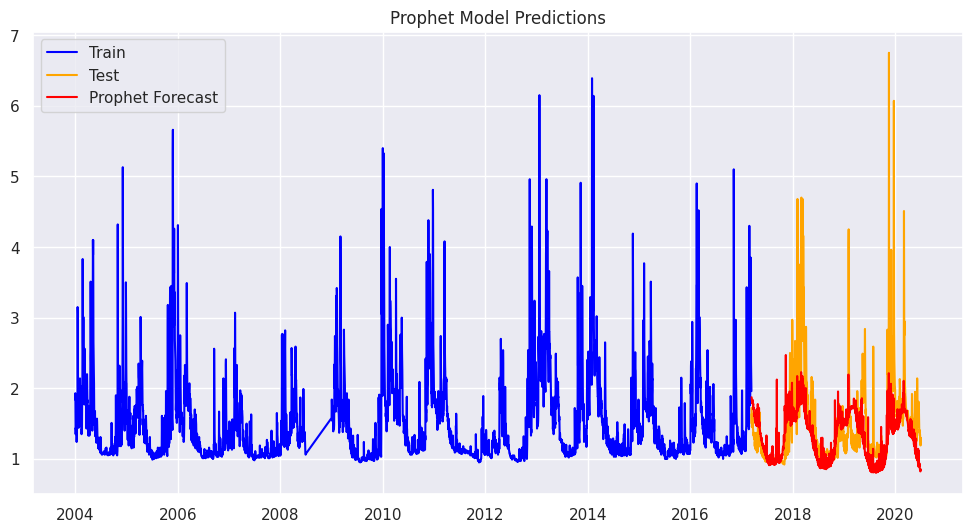

In [43]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for Prophet
prophet_df = df[['Date', 'Hydrometry_Nave_di_Rosano']].rename(columns={'Date': 'ds', 'Hydrometry_Nave_di_Rosano': 'y'})

# Add regressors (exogenous variables)
for regressor in ['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_Vernio', 'Temperature_Firenze']:
    prophet_df[regressor] = df[regressor]

# Split into training and test sets
train_size = int(len(df) * 0.8)  # 80% for training
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Create model
model_prophet = Prophet()

# Add regressors to the model
for regressor in ['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_Vernio', 'Temperature_Firenze']:
    model_prophet.add_regressor(regressor)

# Fit Prophet model
model_prophet.fit(train_prophet)

# Create a DataFrame for predictions
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='D')  # future dates for forecasting

# Add regressors to the future DataFrame
for regressor in ['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata', 'Rainfall_Mangona', 'Rainfall_Vernio', 'Temperature_Firenze']:
    future[regressor] = prophet_df[regressor].values[:len(future)]  # Ensure correct length of regressors in future dataframe

# Predict
forecast = model_prophet.predict(future)

# Extract predictions for the test set
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds'], 'yhat']

# Evaluate model performance
mae_prophet = mean_absolute_error(test_prophet['y'], prophet_forecast)
mse_prophet = mean_squared_error(test_prophet['y'], prophet_forecast)
print(f'Prophet MAE: {mae_prophet:.3f}, MSE: {mse_prophet:.3f}')

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train', color='blue')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test', color='orange')
plt.plot(test_prophet['ds'], prophet_forecast, label='Prophet Forecast', color='red')
plt.title('Prophet Model Predictions')
plt.legend()
plt.show()

In [45]:
# Compare MAE and MSE
print(f"""
Model Comparison:
-----------------
ARIMA     -> MAE: {mae_arima:.3f}, MSE: {mse_arima:.3f}
AutoARIMA -> MAE: {mae_autoarima:.3f}, MSE: {mse_autoarima:.3f}
Prophet   -> MAE: {mae_prophet:.3f}, MSE: {mse_prophet:.3f}
""")


Model Comparison:
-----------------
ARIMA     -> MAE: 0.418, MSE: 0.354
AutoARIMA -> MAE: 0.439, MSE: 0.371
Prophet   -> MAE: 0.331, MSE: 0.287



**The Prophet model provides better performance in this case compared to ARIMA and Auto-ARIMA models, with an MAE of 0.331 and an MSE of 0.287, demonstrates good performance in predicting Arno river's hydrometric level, capturing overall trends and seasonality of the data.**



---



* https://www.kaggle.com/code/andreshg/timeseries-analysis-a-complete-guide
* https://www.kaggle.com/code/sandhyakrishnan02/time-series-analysis-and-forecasting
